# Kernel Density Estimation

A density estimator is an algorithm which takes a $D$-dimensional datasets and produces an estimate of the $D$-dimensional probability distribution that described the data. _Kernel density estimation_ (KDE) is such an algorithm that, in some senses, takes the mixture-of-Gaussians idea to its extreme: it uses a mixture consisting of one Gaussian component _per point_, resulting in what is essentially a non-parametric estimator of density. Here we will explore the motivation and uses of KDE.

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Motivating KDE: Histograms

A histogram is a form a simple one-dimensional density estimator: it divides the data into discrete bins and counts the number of points that fall in each bin so we can visualize the results in an intuitive manner.

For example, let's use some data drawn from two normal distributions:

In [2]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

We can create a standard count-based histogram with the `plt.hist()` function. By specifying the `density` parameter, we end up with a normalized histogram where the height of the bins reflects the probability density:

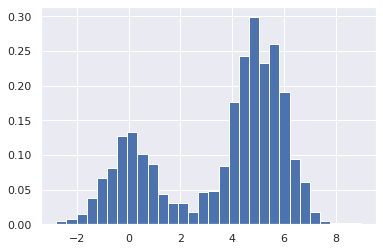

In [3]:
hist = plt.hist(x, bins=30, density=True)

One of the problems of such an use for histograms is that the choice of bin size and location can lead to representation that have qualitatively different features. For example, if we look at a version of this data with only 20 points, these choices can lead to entirely different interpretations of the data:

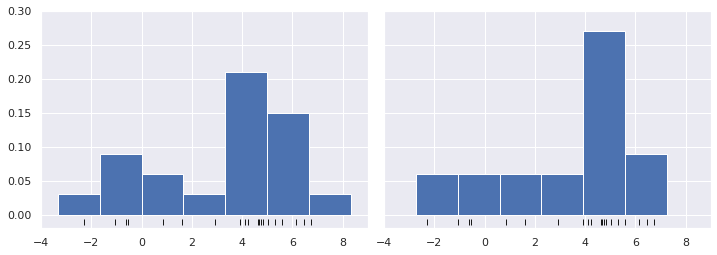

In [4]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                       sharex=True, sharey=True,
                       subplot_kw={'xlim':(-4, 9),
                                   'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, density=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
               markeredgewidth=1)

The histogram on the left clearly indicates that this is a bimodal distribution, while we see a unimodal distribution on the right. With this in mind, how can we trust the intuition that histograms confer? And how might we improve on this?

Taking a step back, we can think of a histogram as a stack of blocks:

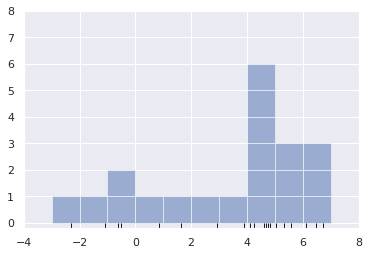

In [5]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k',
        markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1,
                                   alpha=0.5))
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8);

The problems we've had comes from the fact that the height of the block stack often reflects on the coincidence of how the bins align with the data points, instead of the actual density of points nearby. If, instead of stacking the blocks aligned with the _bins_, we were to align them with the _points they represent_, we might get better results. The blocks won't be aligned, but we can still add their contributions at each location along the x-axis to find the result. Let's see this:

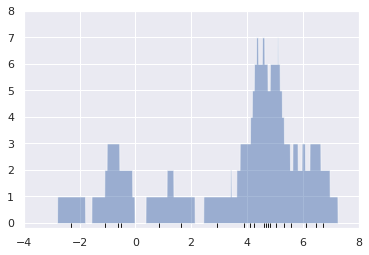

In [6]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8]);

Albeit a bit messy, this is a much more robust reflection of the actual data characteristics than the histograms we've seen previously. We can get a even better and smoother result by replacing the blocks at each location with a smooth function, like a Gaussian. We will use a standard normal curve at each point instead of a block:

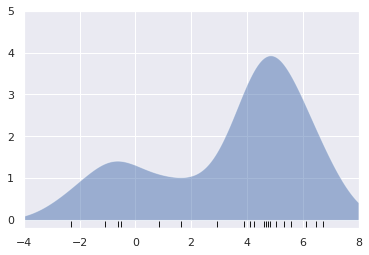

In [7]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

Turns out that these two plots are examples of kernel density estimation in one dimension: the first uses a so-called "tophat" kernel and the second uses a Gaussian kernel.

## Kernel Density Estimation in Practice

Kernel density estimation has two free parameters: the _kernel_, which specifies the shape of the distribution placed at each point, and the _kernel bandwidth_, which controls the size of the kernel at each point.

Scikit-Learn provides a great implementation of KDE because of its efficiency and flexibility. Because KDE can be fairly computationally expensive, the `sklearn.neighbors.KernelDensity` estimator uses a tree-based algorithm under the hood and can trade off some computational time for accuracy using the `atol` (absolute tolerance) and `rtol` (relative tolerance) parameters. 

Let's replicate the above plot using this estimator:

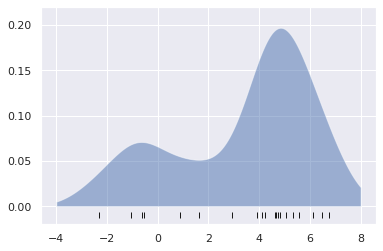

In [8]:
from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22);

### Selecting the bandwidth via cross-validation

The kernel bandwidth is the knob that controls the bias-variance trade-off in the estimate of density: too narrow a bandwidth leads to high-variance estimate (over-fitting). Too wide a bandwidth leads to a high-bias estimate (under-fitting).

In machine learning contexts, such hyperparameter tuning is often done empirically via a cross-validation approach. Here we will use `GridSearchCV` to optimize the bandwidth for the preceding dataset. Since the dataset is so small, we will use leave-one-out cross-validation:

In [9]:
from sklearn.model_selection import GridSearchCV, LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(x[:, None]);

We can now verify the choice of bandwidth that maximizes the score (which in this case default to the log-likelihood):

In [10]:
grid.best_params_

{'bandwidth': 1.1233240329780276}

## Example: Not-So-Naive Bayes

In this example we will take a look at Bayesian generative classification with KDE, and how we can use the Scikit-Learn architecture to create a custom estimator.

For Gaussian naive Bayes, the generative model is a simple axis-aligned Gaussian. Using KDE, we can remove the "naive" element and perform the same classification with a more sophisticated generative model for each class. 

The general approach for this classification is this:

1. Split the training data by label.
2. Fit the KDE to obtain a generative model of the data for each set. With this, for each observation $x$ and label $y$ we can compute a likelihood $P(x~|~y)$.
3. Compute the _class prior_ $P(y)$ from the number of examples of each class in the training set.
4. For an unknown point $x$, the _posterior_ probability for each class is $P(y~|~x) \propto P(x~|~y)P(y)$. The class which maximizes this posterior is the label assigned to the point.

This is the code that implements such algorithm within the Scikit-Learn framework:

In [11]:
from sklearn.base import BaseEstimator, ClassifierMixin


class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

### The anatomy of a custom estimator

Let's now discuss the essential features of this code:

```python
from sklearn.base import BaseEstimator, ClassifierMixin


class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
```

Given that each estimator is a class in Scikit-Learn, it is most convenient for this class to inherit from the `BaseEstimator` class as well as the appropriate mixin, which provides standard functionality. Among other things, one thing to consider is that the `BaseEstimator` contains the logic necessary to clone/copy an estimator for use in a cross-validation procedure, and `ClassifierMixin` defines a default `score()` method used by such routines. 

Next comes the initialization method:

```python
def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
```

In Scikit-Learn, it is important that the initialization _contains no operations_ other than assigning the values passed by name to `self`. This is due to the logic contained in `BaseEstimator` required for cloning and modifying estimators for grid search, and other functions. 

Now to the `fit()` method, where we handle training data:

```python
def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
```

Here we find the unique classes in the training data, train a `KernelDensity` model for each class, and compute the class priors based on the number of input samples. A `fit()` method should always return `self` so that we can chain commands.

Finally, we have the logic for predicting labels:

```python
def predict_proba(self, X):
        logprobs = np.vstack([model.score_samples(X)
                              for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]
```

This a probabilistic classifier, therefore need to implement `predict_proba()` which returns an array of class probabilities. Entry `[i, j]` of such an array is the posterior probability that a sample `i` is a member of class `j`, computed by multiplying the likelihood by the class prior and normalizing. 

Lastly, the `predict()` method just uses these probabilities to return the class with the largest probability.

### Using our custom estimator

We will use this custom estimator on the classification of hand-written digits problem. Here we load the digits and compute the cross-validation score for a range of candidate bandwidths:

In [12]:
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV

digits = load_digits()

bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths})
grid.fit(digits.data, digits.target)

scores = [mean_test_score for mean_test_score in grid.cv_results_['mean_test_score']]

We can now plot the cross-validation score as a function of bandwidth:

{'bandwidth': 6.135907273413174}
accuracy = 0.9677298050139276


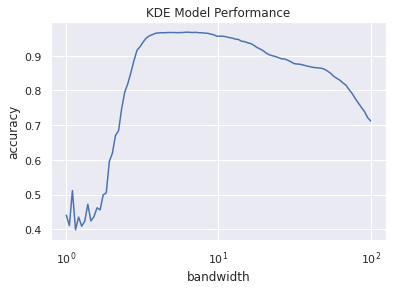

In [13]:
plt.semilogx(bandwidths, scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_)
print('accuracy =', grid.best_score_)

We can see that this not-so-naive Bayesian classifier reaches a cross validation score of over 96%! This is compared to around 80% for the naive Bayesian classification:

In [14]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
cross_val_score(GaussianNB(), digits.data, digits.target).mean()

0.8069281956050759

One benefit of using such a generative classifier it the interpretability of results: for each unknown sample, we not only get a probabilistic classification, but a _full model_ of the distribution of points we are comparing it to. This offers an intuitive window into the reasons for a particular classification that other algorithms such as SVMs and random forests tend to obscure.

As a last note of this section, I'd like to point out that the book goes over a very neat [example](https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html#Example:-KDE-on-a-Sphere) of using KDE for visualization of distributions, which I didn't replicate here since the Basemap toolkit that it uses has been deprecated.